# IPython Notebook containing the Code to reproduce the Figures in the Publication 

This notebook contains the code to reproduce the evaluation on synthetic images presented in the paper. The synthetic images will contain two synthetic laser beams which are defined by a angle, radius and width. Using Perlin noise the images can be altered be more realistic. An example showing two images, one with and one without noise, is shown below. Below the images the corresponding horizontal intensity distribution at different heights is plotted.   


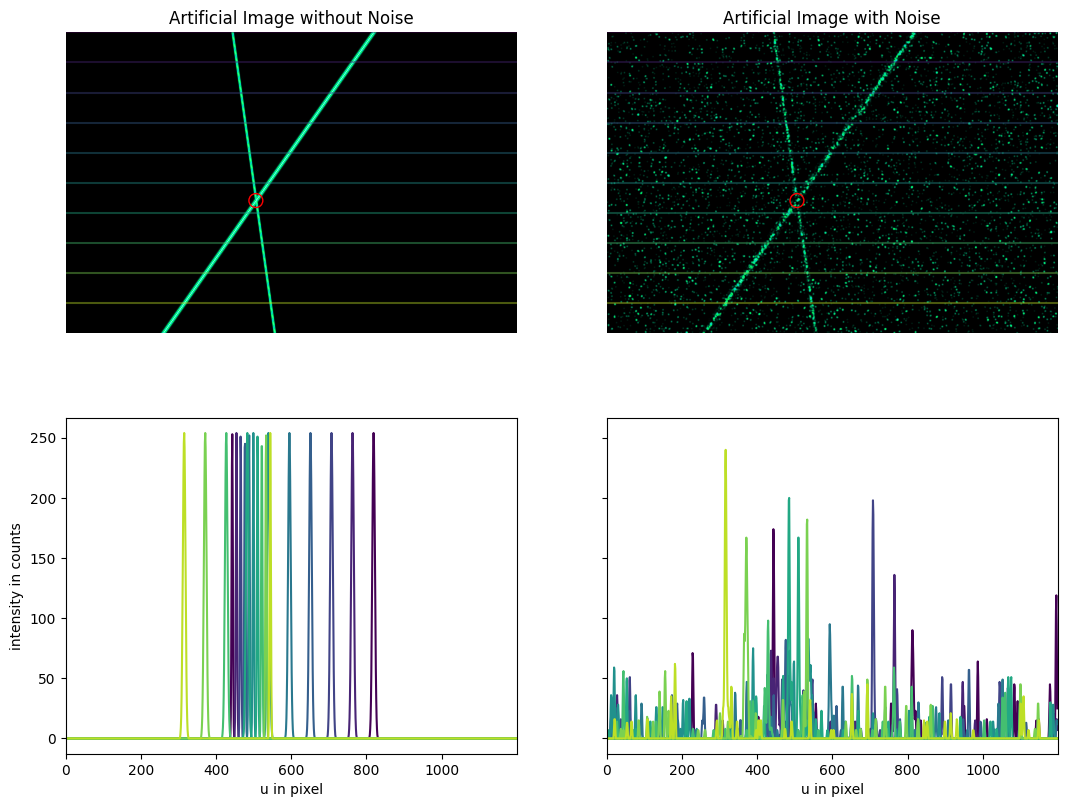

In [26]:
# append parent directory to path to load laser_cross_detection module
import sys

sys.path.insert(0, "..")
import laser_cross_detection as lcd
import utils

from collections import namedtuple
import matplotlib.pyplot as plt

# define image properties
image_width = 1200
image_height = 800

# create container for beam parameter
BeamParameter = namedtuple("BeamParameter", "angle rho width")
# create two sets of beam parameter
beam1 = BeamParameter(angle=215, rho=50, width=12)
beam2 = BeamParameter(angle=172, rho=100, width=7)

# make an artificial laser cross image without noise
noise_free_image = lcd.test.make_noisefree_image(
    width=image_width,
    height=image_height,
    angle1=beam1.angle,
    rho1=beam1.rho,
    beam_width1=beam1.width,
    angle2=beam2.angle,
    rho2=beam2.rho,
    beam_width2=beam2.width,
).T

# make an artificial laser cross image with noise
noisy_image = lcd.test.make_noisy_image(
    width=image_width,
    height=image_height,
    angle1=beam1.angle,
    rho1=beam1.rho,
    beam_width1=beam1.width,
    angle2=beam2.angle,
    rho2=beam2.rho,
    beam_width2=beam2.width,
    add_threshold=0.8,
).T


# calculate exact point of intersection
intersection = lcd.test.solve_for_intersection(
    rho1=beam1.rho,
    theta1=beam1.angle,
    rho2=beam2.rho,
    theta2=beam2.angle,
    offset=(image_width / 2, image_height / 2),
)


# visualize the example images and their intensity profiles
fig, axs = plt.subplots(
    2, 2, figsize=np.multiply(plt.rcParams["figure.figsize"], (2, 2)), sharex=True, sharey="row"
)
# nosie free
axs[0, 0].set_title("Artificial Image without Noise")
axs[0, 0].imshow(noise_free_image, cmap=utils.laser_cmap)
axs[0, 0].scatter(*intersection, fc="none", ec="red", s=100)

for v_sample in np.arange(0, image_height, image_height // 10):
    axs[0, 0].axhline(v_sample, c=plt.cm.viridis(v_sample / image_height), alpha=0.4)
    axs[1, 0].plot(noise_free_image[v_sample], c=plt.cm.viridis(v_sample / image_height))
# noisy
axs[0, 1].set_title("Artificial Image with Noise")
axs[0, 1].imshow(noisy_image, cmap=utils.laser_cmap)
axs[0, 1].scatter(*intersection, fc="none", ec="red", s=100)
for v_sample in np.arange(0, image_height, image_height // 10):
    axs[0, 1].axhline(v_sample, c=plt.cm.viridis(v_sample / image_height), alpha=0.4)
    axs[1, 1].plot(noisy_image[v_sample], c=plt.cm.viridis(v_sample / image_height))

[ax.set_xlabel("u in pixel") for ax in axs[1]]
axs[1, 0].set_ylabel("intensity in counts")
[ax.axis(False) for ax in axs[0]];

In the following different sets of test images will be created. Using the different laser cross detection methods the point of intersection will be detected and compared to the actual point of intersection calculated mathematically based on the beam parameter. The distance between the detected and actual position of the intersection is taken as a measure for accuracy.

_The calculation of the data may take a long while._

In [27]:
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from pathlib import Path
import pickle
from typing import Dict, Tuple

from utils import (
    calculate_distance,
    save_result_dict,
    load_result_dict,
    save_plot,
)

# decide wether to recalculate results or use results from previous evaluation, if present
RECALC = False
# decide wether or not to store plots
SAVE_PLOTS = False
# decide wether or not to use publication figure style (if True scienceplots package is needed)
USE_PUBLICATION_STYLE = False

if USE_PUBLICATION_STYLE:
    import scienceplots

    plotting_style = "science"
else:
    plotting_style = "default"

# define test image dimensions
TEST_IMAGE_WIDTH = 1280
TEST_IMAGE_HEIGHT = 800
TEST_IMAGE_CENTER = TEST_IMAGE_WIDTH / 2, TEST_IMAGE_HEIGHT / 2


methods_dict = dict(
    present=lcd.core.Kluwe(angle_steps=360),
    hough=lcd.core.Hough(),
    ransac=lcd.core.Ransac(),
)

tmp_path = Path("./tmp/")
figure_path = Path("./plots/")


def make_plot(
    results: Dict, x_var: str = "angle", save_path=None, ylim=(None, None)
) -> Tuple[plt.Figure, plt.Axes]:
    """Creating Plots"""
    with plt.style.context(plotting_style):
        fig, ax = plt.subplots()
        ax.set_yscale("log")
        ax.set_ylabel(r"$|p_d - p_t|$ in pixel")
        if x_var == "angle":
            ax.set_xlabel(r"$\theta$ in deg")
            x_values = results["angles"]
        elif x_var == "width":
            ax.set_xlabel(r"$w$ in pixel")
            x_values = results["widths"]
        elif x_var == "noise":
            ax.set_xlabel(r"noise level")
            x_values = results["noise_level"]
        else:
            raise ValueError("x_var must be either angle, noise, or width")

        for label, error in results.items():
            if type(error[0]) is list:
                if len(error[0]) == 1:
                    ax.plot(x_values, np.mean(error, axis=1), label=label)

                elif len(error[0]) > 1:
                    error = np.array(error)
                    error[np.isinf(error)] = np.nan
                    m, s = np.nanmean(error, axis=1), np.nanstd(error, axis=1)
                    (line,) = ax.plot(x_values, m, label=label)
                    ax.fill_between(
                        x_values, m, m + s, color=line.get_color(), alpha=0.3
                    )

        ax.axhline(1, color="k", linewidth=0.5, linestyle="--")
        ax.legend()
        ax.set_ylim(*ylim)

        if save_path and SAVE_PLOTS:
            save_plot(save_path)
    plt.show()
    return fig, ax


# paths to store results for reuse
result_path_dict = dict(
    angles_wo_noise=tmp_path / "angles_without_noise.pickle",
    angles_w_noise=tmp_path / "angles_with_noise.pickle",
    beam_width_wo_noise=tmp_path / "beam_width_without_noise.pickle",
    beam_width_w_noise=tmp_path / "beam_width_with_noise.pickle",
    noise_level=tmp_path / "noise_level.pickle",
)

## Evaluate Angular Dependency

This section creates artificial images of crossing laser beams. The angel between the beams is altered from $2^\circ$ to $90^\circ$ while the rest of the parameters is hold constant. 

In [28]:
fixed_beam_width = 11  # width of the beam in test images
fixed_angle = 45  # angle of the fixed beam
n_angles = 50  # number of angles to evaluate
n_noise_images = 50  # number of different noisy images to generate

angels_to_alter = np.linspace(47, 135, n_angles)

# partial functions for image creation
make_image = partial(
    lcd.test.make_noisefree_image,
    width=TEST_IMAGE_WIDTH,
    height=TEST_IMAGE_HEIGHT,
    beam_width1=fixed_beam_width,
    angle1=fixed_angle,
    rho1=0,
    beam_width2=fixed_beam_width,
    rho2=0,
)

make_noisy_image = partial(
    lcd.test.make_noisy_image,
    width=TEST_IMAGE_WIDTH,
    height=TEST_IMAGE_HEIGHT,
    beam_width1=fixed_beam_width,
    angle1=fixed_angle,
    rho1=0,
    beam_width2=fixed_beam_width,
    rho2=0,
    add_threshold=0.8,
)

# solve for the actual point of intersection (in this case the image center)
intersections = [
    lcd.test.solve_for_intersection(
        rho1=0,
        theta1=fixed_angle,
        rho2=0,
        theta2=angle,
        offset=TEST_IMAGE_CENTER,
    )
    for angle in angels_to_alter
]

### Without Noise

In [29]:
if not result_path_dict["angles_wo_noise"].exists() or RECALC:
    test_images = [
        make_image(
            angle2=angle,
        ).T
        for angle in angels_to_alter
    ]

    results = defaultdict(list)
    results["angles"] = angels_to_alter - fixed_angle

    for name, method in methods_dict.items():
        for image, ac_intsec in zip(
            pbar := tqdm(test_images, desc=f"Method <{name}> "), intersections
        ):
            intersection = method(image)
            distance = calculate_distance(intersection, ac_intsec)

            pbar.set_postfix({"error": f"{distance:.3e}"})
            results[name].append([distance])

    save_result_dict(results, result_path_dict["angles_wo_noise"])

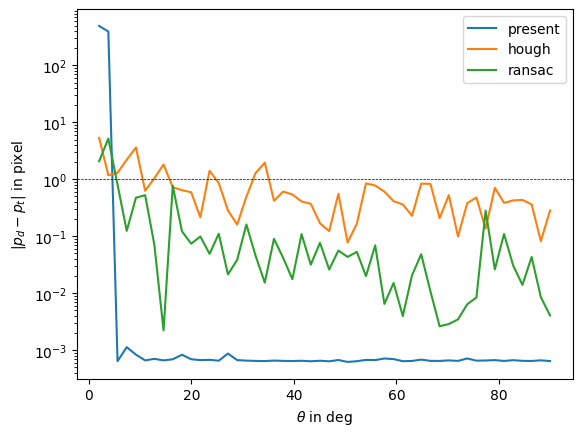

In [30]:
results = load_result_dict(result_path_dict["angles_wo_noise"])

fig, ax = make_plot(
    results, x_var="angle", save_path=figure_path / "angles_wo_noise.png"
)

### With Noise

In [31]:
if not result_path_dict["angles_w_noise"].exists() or RECALC:
    intersections = [
        lcd.test.solve_for_intersection(
            rho1=0, theta1=fixed_angle, rho2=0, theta2=angle
        )
        + TEST_IMAGE_CENTER
        for angle in angels_to_alter
    ]

    results = defaultdict(list)
    results["angles"] = angels_to_alter - fixed_angle

    for name, method in methods_dict.items():
        for angle, ac_intsec in zip(
            pbar := tqdm(angels_to_alter, desc=f"Method <{name}> "),
            intersections,
        ):
            test_images = [
                make_noisy_image(angle2=angle, seed=i).T
                for i in range(n_noise_images)
            ]

            distance = []
            for j, image in enumerate(test_images):

                try:
                    intersection = method(image)
                    distance.append(
                        calculate_distance(intersection, ac_intsec)
                    )
                except:
                    distance.append(np.nan)
                pbar.set_postfix(
                    {
                        "error": f"{distance[-1]:.3e} px",
                        "image": f"{j+1:d}/{n_noise_images:d}",
                    }
                )

            results[name].append(distance)

    save_result_dict(results, result_path_dict["angles_w_noise"])

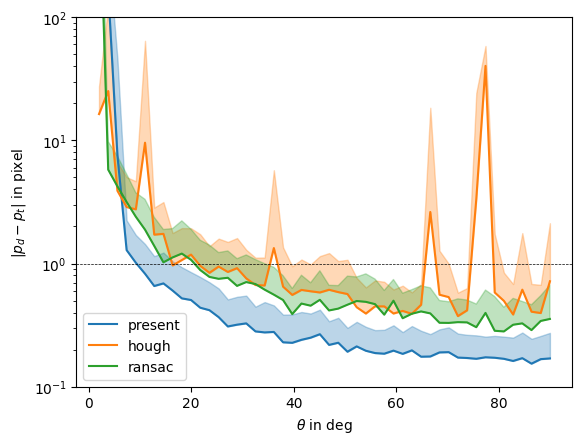

In [32]:
results = load_result_dict(result_path_dict["angles_w_noise"])
fig, ax = make_plot(
    results,
    x_var="angle",
    save_path=figure_path / "angles_w_noise.png",
    ylim=(1e-1, 1e2),
)

## Evaluate Beam Width Dependency

In this section the width of the beams in the artificial images is altered and the effect on the accuracy is investigated. The beam width is altered from $3$ to $100$ pixel in $50$ equally spaced steps.

In [33]:
n_widths = 50
n_noise_images = 50
beam_widths_to_alter = np.linspace(3, 100, n_widths)


make_image = partial(
    lcd.test.make_noisefree_image,
    width=TEST_IMAGE_WIDTH,
    height=TEST_IMAGE_HEIGHT,
    angle1=45,
    rho1=0,
    angle2=135,
    rho2=0,
)

make_noisy_image = partial(
    lcd.test.make_noisy_image,
    width=TEST_IMAGE_WIDTH,
    height=TEST_IMAGE_HEIGHT,
    angle1=45,
    rho1=0,
    angle2=135,
    rho2=0,
    add_threshold=0.8,
)

theoretical_intersection = lcd.test.solve_for_intersection(
    0, 45, 0, 135, offset=TEST_IMAGE_CENTER
)

### Without Noise

In [34]:
methods_dict = dict(
    present=lcd.core.Kluwe(angle_steps=45),
    hough=lcd.core.Hough(),
    ransac=lcd.core.Ransac(),
)

if not result_path_dict["beam_width_wo_noise"].exists() or RECALC:
    test_images = [
        make_image(
            beam_width1=beam_width,
            beam_width2=beam_width,
        ).T
        for beam_width in beam_widths_to_alter
    ]

    results = defaultdict(list)
    results["widths"] = beam_widths_to_alter

    for name, method in methods_dict.items():
        for image in (pbar := tqdm(test_images, desc=f"Method <{name}> ")):
            intersection = method(image)
            distance = calculate_distance(
                intersection, theoretical_intersection
            )
            pbar.set_postfix({"error": f"{distance:.3e}"})
            results[name].append([distance])

    save_result_dict(results, result_path_dict["beam_width_wo_noise"])

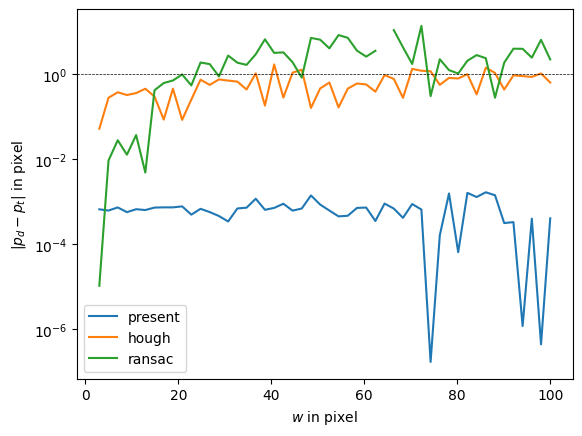

In [35]:
result = load_result_dict(result_path_dict["beam_width_wo_noise"])
fig, ax = make_plot(
    result, x_var="width", save_path=figure_path / "beam_width_wo_noise.png"
)

### With Noise

In [36]:
if not result_path_dict["beam_width_w_noise"].exists() or RECALC:

    results = defaultdict(list)
    results["widths"] = beam_widths_to_alter

    for name, method in methods_dict.items():
        for beam_width in (
            pbar := tqdm(beam_widths_to_alter, desc=f"Method <{name}> ")
        ):
            test_images = [
                make_noisy_image(
                    beam_width1=beam_width, beam_width2=beam_width, seed=i
                ).T
                for i in range(n_noise_images)
            ]

            distance = []
            for j, image in enumerate(test_images):

                intersection = method(image)
                distance.append(
                    calculate_distance(intersection, theoretical_intersection)
                )

                pbar.set_postfix(
                    {
                        "error": f"{distance[-1]:.3e} px",
                        "image": f"{j+1:d}/{n_noise_images:d}",
                    }
                )

            results[name].append(distance)

    save_result_dict(results, result_path_dict["beam_width_w_noise"])

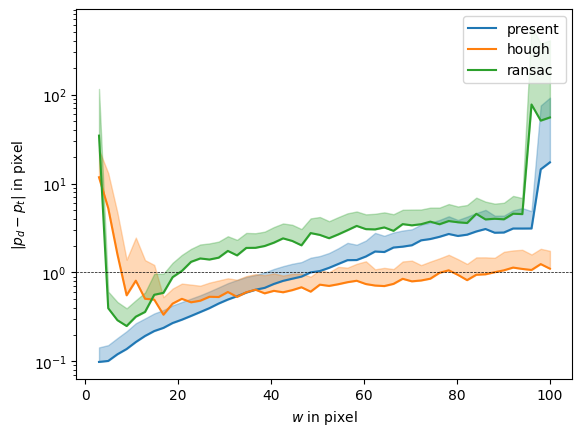

In [37]:
result = load_result_dict(result_path_dict["beam_width_w_noise"])
fig, ax = make_plot(
    result, x_var="width", save_path=figure_path / "beam_width_w_noise.png"
)

## Investigate Noise Level

The final parameter to investigate is the noise level. By keeping the parameters of the beam constant, the level of noise in the images is increased. This evaluation is used to quantify the robustness of the respective method.

In [38]:
result_path_dict.update(dict())

n_noise_images = 50
noise_add_thresh = np.linspace(0.0, 0.55, 50)

make_noisy_image = partial(
    lcd.test.make_noisy_image,
    width=TEST_IMAGE_WIDTH,
    height=TEST_IMAGE_HEIGHT,
    beam_width1=7,
    angle1=45,
    rho1=0,
    beam_width2=7,
    angle2=135,
    rho2=0,
)


theoretical_intersection = lcd.test.solve_for_intersection(
    0, 45, 0, 135, offset=TEST_IMAGE_CENTER
)

In [39]:
if not result_path_dict["noise_level"].exists() or RECALC:

    results = defaultdict(list)
    results["noise_level"] = noise_add_thresh

    for name, method in methods_dict.items():
        for threshold, ac_intsec in zip(
            pbar := tqdm(noise_add_thresh, desc=f"Method <{name}> "),
            intersections,
        ):
            test_images = [
                make_noisy_image(seed=i, add_threshold=1 - threshold).T
                for i in range(n_noise_images)
            ]
            distance = []
            for j, image in enumerate(test_images):
                try:
                    intersection = method(image)
                    distance.append(
                        calculate_distance(intersection, ac_intsec)
                    )
                except:
                    distance.append(np.nan)
                pbar.set_postfix(
                    {
                        "error": f"{distance[-1]:.3e} px",
                        "image": f"{j+1:d}/{n_noise_images:d}",
                    }
                )

            results[name].append(distance)

    save_result_dict(results, result_path_dict["noise_level"])

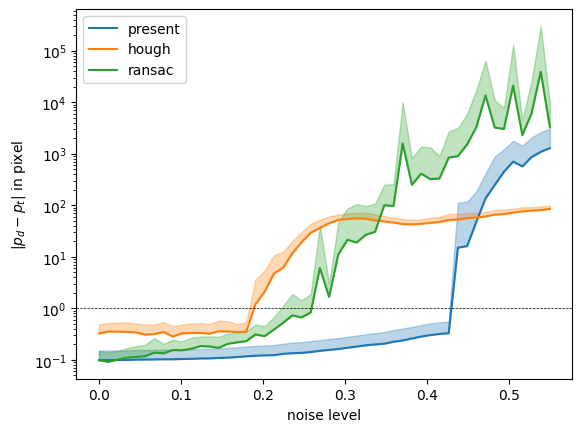

In [48]:
result = load_result_dict(result_path_dict["noise_level"])
result["noise_level"] = noise_add_thresh
make_plot(result, x_var="noise", save_path=figure_path / "noise.png");

## Example Images to show different Noise Levels

The images below show artificial images with different noise levels. 

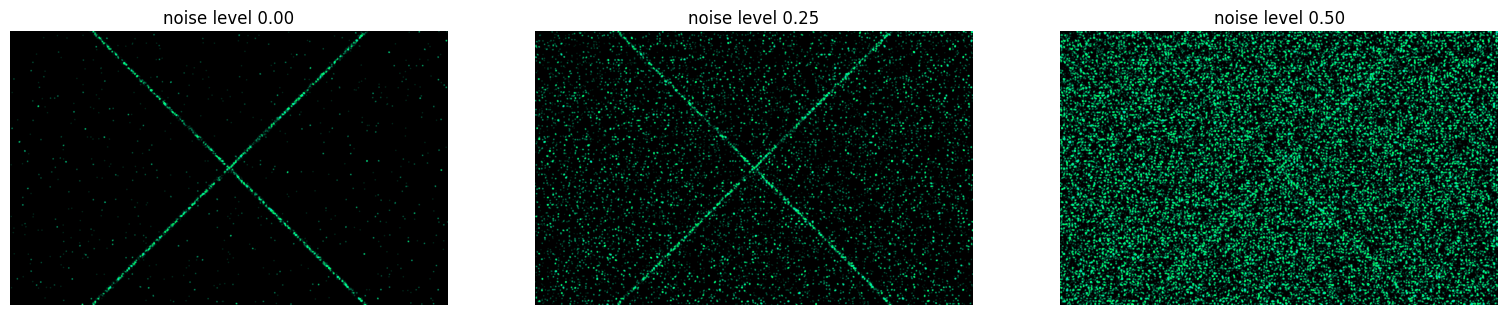

In [47]:
make_image = partial(
    lcd.test.make_noisefree_image,
    width=TEST_IMAGE_WIDTH,
    height=TEST_IMAGE_HEIGHT,
    beam_width1=7,
    angle1=45,
    rho1=0,
    beam_width2=7,
    angle2=135,
    rho2=0,
)

n_samples = 3

fig, axs = plt.subplots(
    1,
    n_samples,
    sharex=True,
    sharey=True,
    figsize=np.multiply(plt.rcParams["figure.figsize"], (3, 1)),
)

noise_free_image = make_image(angle2=135)
for tax, t in zip(axs, np.linspace(0, 0.5, n_samples)):

    image = make_noisy_image(angle2=135, add_threshold=1 - t)
    tax.set_title(f"noise level {t:.2f}")
    tax.axis(False)
    tax.imshow(image.T, vmin=0, vmax=255, cmap=utils.laser_cmap)
